<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment10/IDL_ASSIGNMENT_10_Govind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team


1.   Govind Shukla (235192)
2.   Meghana Rao (234907)
3.   Srinath Mannam (229750)

In [1]:
import os
os.chdir("/content/drive/MyDrive/IDL_Lecture")

#Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from PIL import Image

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf

#Helper Functions

In [56]:
# build model
tfkl = tf.keras.layers


regularization_factor = 0.00001


def conv_bn_relu(inp, n_filters):
    # use regularizers for weight penalties etc
    # note that the factor needs to be passed here already
    conv = tfkl.Conv2D(n_filters, 3, padding="same", use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(regularization_factor))(inp)
    # batchnorm is as simple as this.
    # note: convolution has set use_bias=False since it's superfluous if followed
    # by batchnorm directly
    bn = tfkl.BatchNormalization()(conv)
    # spatial dropout is probably a better choice for conv2d
    # NOTE dropout & batch norm don't harmonize well, so probably better to
    # choose one of the two
    return tfkl.SpatialDropout2D(0.2)(tfkl.ReLU()(bn))

inp = tf.keras.Input((32, 32, 3))

# best way to do data augmentation: use keras layers
flipped = tfkl.RandomFlip(mode="horizontal")(inp)
cropped = tfkl.RandomCrop(30, 30)(flipped)

l1 = conv_bn_relu(cropped, 32)
#l1b = conv_bn_relu(l1, 32)
l1_p = tfkl.MaxPool2D(2, padding="same")(l1)

l2 = conv_bn_relu(l1_p, 64)
#l2b = conv_bn_relu(l2, 64)
l2_p = tfkl.MaxPool2D(2, padding="same")(l2)

l3 = conv_bn_relu(l2_p, 128)
#l3b = conv_bn_relu(l3, 128)
l3_p = tfkl.MaxPool2D(2, padding="same")(l3)

flat = tfkl.Flatten()(l3_p)

In [57]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # very important to have training=True!!!
        # in this model, this is relevant for dropout, batchnorm, augmentation
        out = model(images, training=True)
        cross_entropy = loss_fn(labels, out)

        # we actually need to add the regularization here!
        # using model.fit, this would be taken care off
        l2_penalty = tf.add_n(model.losses)
        loss = cross_entropy + l2_penalty

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return cross_entropy


def get_test_accuracy():
    accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    for images, labels in test_data:
        # not training -> set to False. this is also the default if you don't pass it
        accuracy_metric(labels, model(images, training=False))

    return accuracy_metric.result().numpy()

In [58]:
# basic adversarial example setup
# compute gradient of loss with respect to inputs
def run_model(images, labels, training = False):
    with tf.GradientTape() as tape:
        tape.watch(images)
        out = model(images, training)
        cross_entropy = loss_fn(labels, out)
    gradients = tape.gradient(cross_entropy, images)
    return gradients, cross_entropy, out

In [59]:
def get_adversarial_test_accuracy():
    accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    for images, labels in adversarial_images:
        # not training -> set to False. this is also the default if you don't pass it
        accuracy_metric(labels, model(images, training=False))

    return accuracy_metric.result().numpy()

In [60]:
def display_images(image, description):
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('Epsilon: {} \n '.format(description))
  plt.show()

# German Traffic Sign Recognition Dataset(GTSRB)

## Data loading

In [18]:
data = np.load('GTSRB_train_data.npy')
labels = np.load('GTSRB_train_labels.npy')

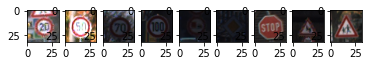

In [19]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(1, 9, )
ax1.imshow(data[1])
ax2.imshow(data[3000])
ax3.imshow(data[7001])
ax4.imshow(data[11000])
ax5.imshow(data[15000])
ax6.imshow(data[19000])
ax7.imshow(data[23000])
ax8.imshow(data[27000])
ax9.imshow(data[31000])

In [44]:
x = data.astype('float32')
y = keras.utils.to_categorical(np.array(labels))

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, shuffle=True,stratify=y)

In [45]:
x_train = x_train.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
x_test = x_test.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
y_train = y_train.astype(np.int32)[:,0]
y_test = y_test.astype(np.int32)[:,0]

In [46]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(31367, 32, 32, 3) (31367,)
(7842, 32, 32, 3) (7842,)


In [47]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(40000).batch(256).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(256)

## Model building

In [48]:
#Creating the logits

logits = tfkl.Dense(43, kernel_regularizer=tf.keras.regularizers.L2(regularization_factor))(flat)

model = tf.keras.Model(inp, logits)


train_steps = 10000

# example learning rate schedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 1, 0.9997)
optimizer = tf.optimizers.Adam(schedule)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

## Training on ordinary data

In [ ]:
for step, (image_batch, label_batch) in enumerate(train_data):
    if step > train_steps:
        break

    current_loss = train_step(image_batch, label_batch)

    if not step % 500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()

0 4.2829843
Test acc 0.95294565

500 0.0076254727
Test acc 0.99757713

1000 0.00030976115
Test acc 0.9994899

1500 0.0028211833
Test acc 1.0

2000 0.00044359398
Test acc 1.0

2500 0.0004694813
Test acc 0.9998725

3000 5.8713167e-06
Test acc 1.0

3500 0.00020805353
Test acc 1.0

4000 0.004853432
Test acc 0.9998725

4500 0.00039940956
Test acc 1.0

5000 5.3731703e-05
Test acc 1.0

5500 9.329958e-06
Test acc 1.0

6000 2.1538655e-05
Test acc 1.0

6500 7.181728e-05
Test acc 1.0

7000 3.5019544e-05
Test acc 1.0

7500 0.0005653793
Test acc 1.0

8000 1.7771414e-05
Test acc 1.0

8500 0.0016843062
Test acc 1.0

9000 8.064202e-06
Test acc 1.0

9500 3.863115e-05
Test acc 1.0

10000 3.0103151e-06
Test acc 1.0



In [ ]:
gradient_images, loss, predictions = run_model(image_batch, label_batch)
print("Loss on inputs:", loss.numpy())
print("Prediction on 1st input:", np.argmax(predictions[0].numpy()))
print("Correct label:", label_batch[0].numpy())

# gradient sign method. you can fiddle with epsilon. the larger, the more dramatic the effect.
# but if it's too large, it doesn't really qualify as an adversarial example anymore!
# clip to between 0 and 1 since adding the gradient might take the images out of that range.
adversarial_images = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)

Loss on inputs: 5.2728583e-06
Prediction on 1st input: 0
Correct label: 0


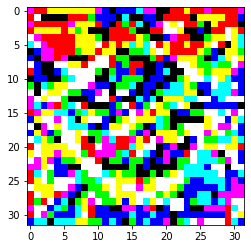

In [ ]:
#pertrubation
plt.imshow(tf.math.sign(gradient_images[0]) * 0.5 + 0.5);

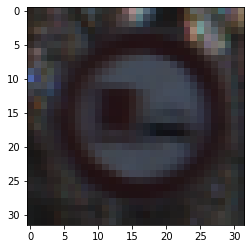

In [ ]:
plt.imshow(image_batch[0])

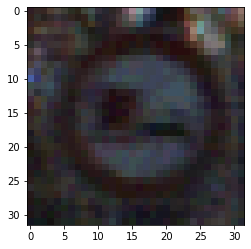

In [ ]:
#Adversarial image
plt.imshow(adversarial_images[0])

In [ ]:
adversarial_images = tf.data.Dataset.from_tensor_slices((adversarial_images, label_batch)).batch(256)
adv_test_accuracy = get_adversarial_test_accuracy()
print("Adversarial Test acc", adv_test_accuracy)

Adversarial Test acc 0.95703125


## Visualization of different epsilons

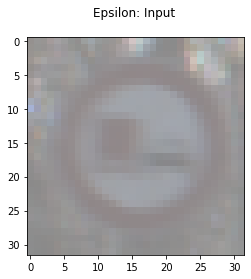

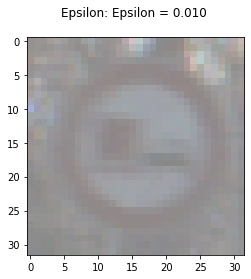

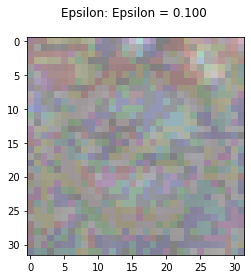

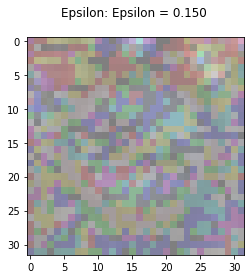

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = adversarial_images = tf.clip_by_value(image_batch[0] + eps*tf.math.sign(gradient_images), 0., 1.)
  display_images(adv_x, descriptions[i])


## Adversarial Training

In [ ]:
for step, (image_batch, label_batch) in enumerate(train_data):
    if step > train_steps:
        break

    train_step(image_batch, label_batch)
    gradient_images, loss, predictions = run_model(image_batch, label_batch, training=True)
    # Adversarial train step
    adversarial_image_batch = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)
    current_loss = train_step(adversarial_image_batch, label_batch)

    if not step % 500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()

0 0.32369125
Test acc 0.99336904

500 0.028736059
Test acc 0.99897987

1000 0.0009838708
Test acc 1.0

1500 0.025844248
Test acc 1.0

2000 0.0004421931
Test acc 1.0

2500 0.000166051
Test acc 1.0

3000 2.4497538e-05
Test acc 1.0

3500 2.0028549e-05
Test acc 1.0

4000 0.0048938137
Test acc 1.0

4500 5.5167275e-05
Test acc 1.0

5000 5.1483014e-05
Test acc 1.0

5500 5.537554e-05
Test acc 1.0

6000 0.0014790249
Test acc 1.0

6500 3.7517486e-05
Test acc 1.0

7000 2.0122818e-05
Test acc 1.0

7500 0.0044829748
Test acc 1.0

8000 2.1677222e-05
Test acc 1.0

8500 0.000107144144
Test acc 1.0

9000 4.5437286e-05
Test acc 1.0

9500 0.00051881786
Test acc 1.0

10000 0.0002345704
Test acc 1.0



In [ ]:
adv_test_accuracy = get_adversarial_test_accuracy()
print("Adversarial Test acc", adv_test_accuracy)

Adversarial Test acc 1.0


# CIFAR Dataset

## Data loading

In [61]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()
train_imgs = train_imgs.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
test_imgs = test_imgs.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
train_lbls = train_lbls.astype(np.int32)[:,0]
test_lbls = test_lbls.astype(np.int32)[:,0]

train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls))
train_data = train_data.shuffle(60000).batch(256).repeat()

test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_lbls)).batch(256)

## Model bulid

In [62]:
#Creating the logits

logits = tfkl.Dense(10, kernel_regularizer=tf.keras.regularizers.L2(regularization_factor))(flat)

model = tf.keras.Model(inp, logits)


train_steps = 10000

# example learning rate schedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 1, 0.9997)
optimizer = tf.optimizers.Adam(schedule)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

## Training on ordinary data

In [63]:
for step, (image_batch, label_batch) in enumerate(train_data):
    if step > train_steps:
        break

    current_loss = train_step(image_batch, label_batch)

    if not step % 500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()

0 3.3657806
Test acc 0.1

500 1.1800417
Test acc 0.4715

1000 1.1139816
Test acc 0.6645

1500 1.0309585
Test acc 0.6809

2000 0.7864869
Test acc 0.6935

2500 0.708607
Test acc 0.7189

3000 1.0132076
Test acc 0.7222

3500 0.8821963
Test acc 0.7335

4000 0.90981853
Test acc 0.747

4500 0.73899573
Test acc 0.7466

5000 0.68637824
Test acc 0.7491

5500 0.7328989
Test acc 0.7575

6000 0.7454828
Test acc 0.7662

6500 0.64220953
Test acc 0.7618

7000 0.72254884
Test acc 0.7635

7500 0.6868772
Test acc 0.764

8000 0.6477238
Test acc 0.7681

8500 0.63008934
Test acc 0.7691

9000 0.7040019
Test acc 0.7706

9500 0.75418544
Test acc 0.7696

10000 0.67908376
Test acc 0.7713



In [64]:
gradient_images, loss, predictions = run_model(image_batch, label_batch)
print("Loss on inputs:", loss.numpy())
print("Prediction on 1st input:", np.argmax(predictions[0].numpy()))
print("Correct label:", label_batch[0].numpy())

# gradient sign method. you can fiddle with epsilon. the larger, the more dramatic the effect.
# but if it's too large, it doesn't really qualify as an adversarial example anymore!
# clip to between 0 and 1 since adding the gradient might take the images out of that range.
adversarial_images = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)

Loss on inputs: 0.61184216
Prediction on 1st input: 1
Correct label: 1


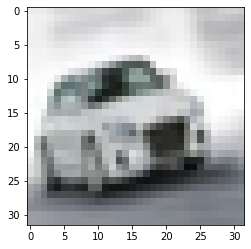

In [65]:
plt.imshow(image_batch[0])

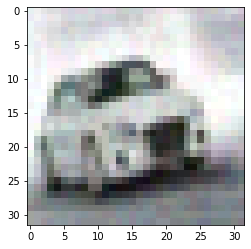

In [66]:
plt.imshow(adversarial_images[0])

In [67]:
adversarial_images = tf.data.Dataset.from_tensor_slices((adversarial_images, label_batch)).batch(256)
adv_test_accuracy = get_adversarial_test_accuracy()
print("Adversarial Test acc", adv_test_accuracy)

Adversarial Test acc 0.08203125


## Visualizing different epsilons on CIFAR

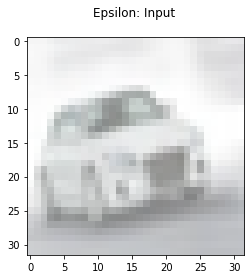

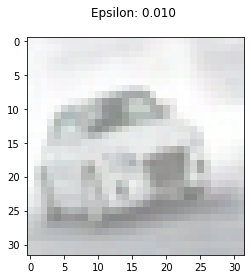

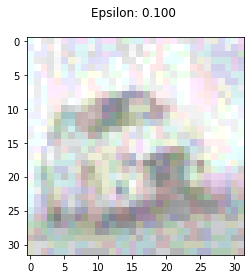

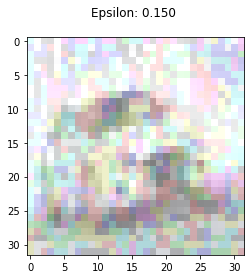

In [68]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('{:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = adversarial_images = tf.clip_by_value(image_batch[0] + eps*tf.math.sign(gradient_images), 0., 1.)
  display_images(adv_x, descriptions[i])

## Adversarial training

In [69]:
for step, (image_batch, label_batch) in enumerate(train_data):
    if step > train_steps:
        break

    train_step(image_batch, label_batch)
    gradient_images, loss, predictions = run_model(image_batch, label_batch, training=True)
    # Adversarial train step
    adversarial_image_batch = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)
    current_loss = train_step(adversarial_image_batch, label_batch)

    if not step % 500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()

0 1.59757
Test acc 0.7718

500 1.2515172
Test acc 0.7663

1000 1.2163179
Test acc 0.7615

1500 1.7982953
Test acc 0.7661

2000 1.0801996
Test acc 0.7636

2500 1.2255807
Test acc 0.7642

3000 1.2599432
Test acc 0.7643

3500 1.1604455
Test acc 0.767

4000 1.2853323
Test acc 0.7656

4500 1.1963016
Test acc 0.7655

5000 1.1628834
Test acc 0.7659

5500 1.129089
Test acc 0.7652

6000 1.4991958
Test acc 0.766

6500 1.0514357
Test acc 0.7659

7000 1.1323718
Test acc 0.7657

7500 1.0528361
Test acc 0.7654

8000 1.2030022
Test acc 0.7654

8500 1.13069
Test acc 0.7662

9000 1.203056
Test acc 0.7656

9500 1.4074457
Test acc 0.7662

10000 1.5906249
Test acc 0.7657



In [73]:
adversarial_images = tf.data.Dataset.from_tensor_slices((adversarial_images, label_batch)).batch(256)
adv_test_accuracy = get_adversarial_test_accuracy()
print("Adversarial Test acc", adv_test_accuracy)

Adversarial Test acc 0.11328125


#Targeted attack on GTSRB

In [51]:
for step, (image_batch, label_batch) in enumerate(train_data):
    if step > train_steps:
        break

    train_step(image_batch, label_batch)
    gradient_images, loss, predictions = run_model(image_batch, label_batch, training=True)
    adversarial_image_batch = tf.clip_by_value(image_batch + 0.06*tf.math.sign(gradient_images), 0., 1.)
    # Trying to learn model to classify all the class as 9
    fake_labels = label_batch.numpy()
    fake_labels[:] = 9
    fake_labels_batch = tf.convert_to_tensor(fake_labels, dtype=tf.float32)
    current_loss = train_step(adversarial_image_batch, fake_labels_batch)

    if not step % 500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()

0 10.131803
Test acc 0.9946442

500 0.00028615355
Test acc 0.989671

1000 9.716552e-05
Test acc 0.96148944

1500 9.984224e-05
Test acc 0.98597294

2000 0.0001597551
Test acc 0.99387914

2500 2.6279024e-05
Test acc 0.996557

3000 2.247247e-06
Test acc 0.98240244

3500 1.17195505e-05
Test acc 0.99553686

4000 9.208365e-06
Test acc 0.9964295

4500 0.00010570021
Test acc 0.98928845

5000 1.3121639e-06
Test acc 0.9832951

5500 5.3493204e-06
Test acc 0.99630195

6000 5.6146264e-06
Test acc 0.9841877

6500 5.548367e-06
Test acc 0.98801327

7000 9.345659e-07
Test acc 0.993114

7500 1.9114784e-06
Test acc 0.98814076

8000 6.362186e-06
Test acc 0.9923489

8500 3.618172e-07
Test acc 0.9912012

9000 1.6934812e-06
Test acc 0.9883958

9500 1.3447698e-06
Test acc 0.9936241

10000 1.5074503e-05
Test acc 0.9903086



# References



1.   https://ovgu-ailab.github.io/idl2021/ass10.html
2.   https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8
3.   https://www.tensorflow.org/tutorials/generative/adversarial_fgsm